# LDA model and DistilBERT model

This file contains the Latent Dirichlet Allocation (LDA) model to identify the topics discussed in the tweets. It also uses the LDA model results to train a DistilBERT model to classify the tweets to the topics. Sentiment analysis was conducted on the topics with a different, pretrained DistilBERT model.

## Data cleaning and preprocessing

In [2]:
import data_preprocessing_cleaned as clean

def clean_data(csv_file:str): 
    df = clean.TweetCleaner(csv_file)
    cleaned_df = df.clean_tweets()
    cleaned_df['preprocessed_text'] = cleaned_df['cleaned_text'].apply(clean.preprocess_text_lemmatization)
    return cleaned_df

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Alan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Alan\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Alan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Alan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Alan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
# load cleaned data

#nltk.download('wordnet')
df = clean_data('twitter_data.csv')

In [4]:
# tokenize and process the text further 
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel

def preprocess(text):
    stop_words = set(stopwords.words('english'))
    additional_stopwords = {'u', 'would', 'amp', 'im', 'ur'}
    stop_words.update(additional_stopwords)
    tokenizer = RegexpTokenizer(r'\w+')
    lemmatizer = WordNetLemmatizer()
    tokens = tokenizer.tokenize(text.lower())
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words and len(token) > 1]
    return tokens

df['processed_text'] = df['cleaned_text'].apply(preprocess)

In [5]:
# remove retweets from data
df = df[df['is_retweet'] != True] 

In [7]:
# Create a corpus from tweets

from gensim.corpora import Dictionary

# Create a Gensim dictionary from the processed text
dictionary = Dictionary(df['processed_text'])

# Filter out extremes to limit the number of features
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

# Create a corpus: a list of bag of words for each document
corpus = [dictionary.doc2bow(doc) for doc in df['processed_text']]


In [8]:
# find optimal number of topics

from gensim.models.coherencemodel import CoherenceModel

# Function to compute coherence values for different number of topics
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

# Use this function to find the optimal number of topics
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=df['processed_text'].tolist(), start=2, limit=40, step=6)




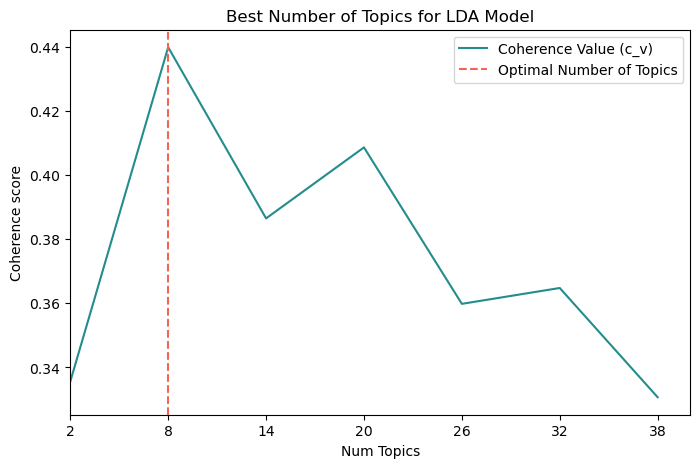

In [9]:
# plot optimal number of topics

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.lines import Line2D

plt.figure(figsize=(8,5))

# Create a custom x-axis
start = 2
limit = 40
step = 6
x = range(start, limit, step)

# Build the line plot
ax = sns.lineplot(x=x, y=coherence_values, color='#238C8C')

# Set titles and labels
plt.title("Best Number of Topics for LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.xlim(start, limit)
plt.xticks(range(2, limit, step))

# Add a vertical line to show the optimum number of topics
plt.axvline(x[np.argmax(coherence_values)], 
            color='#F26457', linestyle='--')

# Draw a custom legend
legend_elements = [Line2D([0], [0], color='#238C8C', 
                          ls='-', label='Coherence Value (c_v)'),
                   Line2D([0], [1], color='#F26457', 
                          ls='--', label='Optimal Number of Topics')]

ax.legend(handles=legend_elements, loc='upper right')


## LDA Model

In [10]:
# Apply LDA
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=8, random_state=100, update_every=1, chunksize=100, passes=10, alpha='auto', per_word_topics=True)



In [11]:
# View the topics
topics = lda_model.print_topics(num_words=10)
for topic in topics:
    print(topic)

(0, '0.073*"womensrightsarehumanrights" + 0.027*"birth" + 0.026*"help" + 0.025*"baby" + 0.023*"resist" + 0.022*"equal" + 0.021*"resistance" + 0.019*"august" + 0.014*"ukraine" + 0.014*"please"')
(1, '0.034*"abortionrightsarehumanrights" + 0.029*"forced" + 0.025*"one" + 0.019*"give" + 0.014*"amendment" + 0.014*"today" + 0.013*"every" + 0.013*"theyre" + 0.013*"fight" + 0.013*"country"')
(2, '0.058*"woman" + 0.047*"life" + 0.046*"enough" + 0.044*"girl" + 0.039*"body" + 0.038*"time" + 0.035*"choice" + 0.030*"potus" + 0.029*"reproductive" + 0.024*"matter"')
(3, '0.048*"year" + 0.028*"voteblue2022" + 0.026*"health" + 0.018*"thing" + 0.018*"victim" + 0.018*"old" + 0.016*"voting" + 0.016*"bansoffourbodies" + 0.016*"apparently" + 0.015*"top"')
(4, '0.026*"court" + 0.025*"make" + 0.021*"scotus" + 0.021*"men" + 0.017*"read" + 0.016*"decision" + 0.014*"also" + 0.012*"punishing" + 0.011*"even" + 0.010*"week"')
(5, '0.149*"womensrights" + 0.029*"child" + 0.029*"republican" + 0.023*"dont" + 0.020*"mus

In [12]:
# Vizualize the LDA results

# pip install pyldavis
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

# feed the LDA model into the pyLDAvis instance
lda_viz = gensimvis.prepare(lda_model, corpus, dictionary, sort_topics=True)

pyLDAvis.display(lda_viz)


In [13]:
# adding LDA results to dataframe

dominant_topics = []
for tweet_corpus in corpus:
    # Get topic distribution for the tweet
    topic_distribution = lda_model.get_document_topics(tweet_corpus)
    # Sort the topics by probability
    topic_distribution = sorted(topic_distribution, key=lambda x: x[1], reverse=True)
    # Get the dominant topic (highest probability) for the tweet
    dominant_topic = topic_distribution[0][0]  # This is the topic number
    dominant_topics.append(dominant_topic)

df['dominant_topic'] = dominant_topics


In [14]:
# See topic words to manually generate topic labels

for idx, topic in lda_model.show_topics(formatted=False, num_words=15):
    print(f"Topic: {idx} \nWords: {', '.join([word for word, _ in topic])}")


Topic: 0 
Words: womensrightsarehumanrights, birth, help, baby, resist, equal, resistance, august, ukraine, please, november, glory, endgunviolence, glorytoukraine, afghanistan
Topic: 1 
Words: abortionrightsarehumanrights, forced, one, give, amendment, today, every, theyre, fight, country, raise, book, abortionisessential, prolife, news
Topic: 2 
Words: woman, life, enough, girl, body, time, choice, potus, reproductive, matter, future, sexual, era, denied, ensure
Topic: 3 
Words: year, voteblue2022, health, thing, victim, old, voting, bansoffourbodies, apparently, top, may, everyone, biden, better, valdemings
Topic: 4 
Words: court, make, scotus, men, read, decision, also, punishing, even, week, many, overturning, going, supreme, story
Topic: 5 
Words: womensrights, child, republican, dont, must, history, adulthumanfemale, know, equality, back, freedom, new, stop, away, cant
Topic: 6 
Words: mybodymychoice, gop, like, day, take, fbr, thank, always, keep, government, reproductiverights

In [15]:
# Topic labels
topic_labels = {
    0: "Current Events",
    1: "Abortion Rights Debate",
    2: "Women's Health and Reproductive Rights",
    3: "Political Advocacy and Voting",
    4: "Supreme Court and Legal Discussions",
    5: "Equality and Freedom",
    6: "Personal Rights and Political Critique",
    7: "Roe vs. Wade Discussion"
}


# Function to apply labels to topics
def label_topic(topic_id):
    return topic_labels.get(topic_id, "Unknown Topic")  # Default to "Unknown Topic" if no label

df['topic_label'] = [label_topic(topic_id) for topic_id in df['dominant_topic']]


In [16]:
# Count tweets per topic
tweet_counts_per_topic = df['topic_label'].value_counts()
print(tweet_counts_per_topic)


topic_label
Roe vs. Wade Discussion                   108464
Equality and Freedom                        2279
Supreme Court and Legal Discussions         1485
Current Events                              1113
Women's Health and Reproductive Rights      1015
Abortion Rights Debate                       562
Personal Rights and Political Critique       433
Political Advocacy and Voting                 46
Name: count, dtype: int64


In [17]:
# save dataframe for later use
df.to_pickle("twitter_data_LDA.pkl")

## DistilBERT Model

In [23]:
# Preparing Data for DistilBERT Classification

from transformers import DistilBertTokenizer, DistilBertModel
import torch

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=len(topic_labels))

# Tokenize the text
encodings = tokenizer(df['cleaned_text'].tolist(), truncation=True, padding='max_length', max_length=512, return_tensors="pt")

# Ensure labels are a tensor with the correct shape
labels = torch.tensor(df['topic_label'].map(label_to_id).tolist())


In [24]:
# split dataset for model Training

from sklearn.model_selection import train_test_split
from transformers import DistilBertForSequenceClassification, Trainer, TrainingArguments

# Split the data
train_texts, val_texts, train_labels, val_labels = train_test_split(
    encodings['input_ids'], labels, test_size=0.2, random_state=42)

# Since attention masks are also important for training, split them as well
train_masks, val_masks, _, _ = train_test_split(
    encodings['attention_mask'], labels, test_size=0.2, random_state=42)


In [25]:
# Prepare Data for PyTorch
import torch

class TweetDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Create PyTorch datasets
train_dataset = TweetDataset({'input_ids': train_texts, 'attention_mask': train_masks}, train_labels)
val_dataset = TweetDataset({'input_ids': val_texts, 'attention_mask': val_masks}, val_labels)


In [35]:
# Define Training Arguments

# pip install transformers[torch]
training_args = TrainingArguments(
    output_dir='./results',          # output directory for model predictions and checkpoints
    num_train_epochs=1,              # number of training epochs
    per_device_train_batch_size=64,  # batch size for training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
    evaluation_strategy="epoch",     # evaluate each `logging_steps`
)

# Initialize the Trainer
trainer = Trainer(
    model=model,                         # the instantiated Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset             # evaluation dataset
)


In [36]:
# Train and evaluate model
trainer.train()
trainer.evaluate()

C:\Users\Alan\AppData\Local\Temp\ipykernel_23208\3147883311.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
C:\Users\Alan\AppData\Local\Temp\ipykernel_23208\3147883311.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])


Epoch,Training Loss,Validation Loss
1,0.124800,0.113187


C:\Users\Alan\AppData\Local\Temp\ipykernel_23208\3147883311.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
C:\Users\Alan\AppData\Local\Temp\ipykernel_23208\3147883311.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])
C:\Users\Alan\AppData\Local\Temp\ipykernel_23208\3147883311.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
C:\Us

{'eval_loss': 0.11318653076887131,
 'eval_runtime': 13663.8995,
 'eval_samples_per_second': 1.689,
 'eval_steps_per_second': 0.026,
 'epoch': 1.0}

In [37]:
# save the model and tokenizer

model_dir = './distilbert_model_v01'


model.save_pretrained(model_dir)

tokenizer.save_pretrained(model_dir)

('./distilbert_model_v01\\tokenizer_config.json',
 './distilbert_model_v01\\special_tokens_map.json',
 './distilbert_model_v01\\vocab.txt',
 './distilbert_model_v01\\added_tokens.json')

In [18]:
# import model and tokenizer

from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

model_dir = './distilbert_model_v01'

# Load the tokenizer
tokenizer = DistilBertTokenizer.from_pretrained(model_dir)

# Load the model
model = DistilBertForSequenceClassification.from_pretrained(model_dir)


C:\Users\Alan\anaconda3\Lib\site-packages\transformers\utils\generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
C:\Users\Alan\anaconda3\Lib\site-packages\transformers\utils\generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [23]:
# Predict topics with DisilBERT Model

from torch.utils.data import DataLoader
import torch

def predict_topics_in_batches(texts, model, tokenizer, batch_size=16):
    model.eval()  # Put model in evaluation mode
    predictions = []

    # Create DataLoader for batch processing
    dataloader = DataLoader(texts, batch_size=batch_size)

    for batch in dataloader:
        # Tokenize texts in the batch
        encodings = tokenizer(batch, truncation=True, padding=True, return_tensors="pt")
        input_ids = encodings['input_ids'].to(model.device)
        attention_mask = encodings['attention_mask'].to(model.device)

        with torch.no_grad():  # Do not calculate gradients
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            batch_predictions = torch.argmax(logits, dim=1).tolist()
            predictions.extend(batch_predictions)

    return predictions

topic_predictions = predict_topics_in_batches(df['cleaned_text'].tolist(), model, tokenizer)

df['predicted_topic'] = topic_predictions

In [24]:
# Map Numeric Topics to Descriptive Labels
df['predicted_topic_label'] = df['predicted_topic'].apply(lambda x: topic_labels.get(x, "Unknown"))

In [28]:
# See topic counts
tweet_counts_per_topic_DistilBERT = df['predicted_topic_label'].value_counts()
print(tweet_counts_per_topic_DistilBERT)

predicted_topic_label
Roe vs. Wade Discussion                   110963
Equality and Freedom                        1420
Current Events                              1092
Women's Health and Reproductive Rights       994
Supreme Court and Legal Discussions          401
Abortion Rights Debate                       277
Personal Rights and Political Critique       250
Name: count, dtype: int64


## Sentiment Analysis

In [29]:
#Sentiment Analysis

from transformers import pipeline

unique_topics = df['predicted_topic_label'].unique()

# Load pre-trained sentiment analysis pipeline
sentiment_pipeline = pipeline("sentiment-analysis")

# Function to perform sentiment analysis
def analyze_sentiment(texts):
    return sentiment_pipeline(texts)

# Iterate over each unique topic
for topic in unique_topics:
    print(f"Analyzing sentiment for topic: {topic}")
    texts_to_analyze = df[df['predicted_topic_label'] == topic]['cleaned_text'].tolist()
    
    # Perform sentiment analysis
    sentiments = analyze_sentiment(texts_to_analyze)
    
    # Since the analysis could be slow, we print progress
    print(f"Completed sentiment analysis for topic: {topic}")
    
    # Store sentiment results
    sentiment_labels = [sentiment['label'] for sentiment in sentiments]
    
    # It's more efficient to add all sentiments at once rather than row by row
    df.loc[df['predicted_topic_label'] == topic, 'sentiment'] = sentiment_labels

# Calculate the sentiment distribution for each topic
for topic in unique_topics:
    sentiment_distribution = df[df['predicted_topic_label'] == topic]['sentiment'].value_counts(normalize=True)
    print(f"\nSentiment distribution for topic '{topic}':\n{sentiment_distribution}")


No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
C:\Users\Alan\anaconda3\Lib\site-packages\ipywidgets\widgets\widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
C:\Users\Alan\anaconda3\Lib\site-packages\ipywidgets\widgets\widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
C:\Users\Alan\anaconda3\Lib\site-packages\ipywidgets\widgets\widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use t

C:\Users\Alan\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Alan\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
C:\Users\Alan\anaconda3\Lib\site-packages\ipywidgets\widgets\widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Pl

C:\Users\Alan\anaconda3\Lib\site-packages\ipywidgets\widgets\widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
C:\Users\Alan\anaconda3\Lib\site-packages\ipywidgets\widgets\widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
C:\Users\Alan\anaconda3\Lib\site-packages\ipywidgets\widgets\widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
C:\Users\Alan\anaconda3\Lib\site-packages\ipywidgets\widgets\widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Pleas

C:\Users\Alan\anaconda3\Lib\site-packages\ipywidgets\widgets\widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
C:\Users\Alan\anaconda3\Lib\site-packages\ipywidgets\widgets\widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
C:\Users\Alan\anaconda3\Lib\site-packages\ipywidgets\widgets\widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
C:\Users\Alan\anaconda3\Lib\site-packages\ipywidgets\widgets\widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Pleas

Analyzing sentiment for topic: Roe vs. Wade Discussion
Completed sentiment analysis for topic: Roe vs. Wade Discussion
Analyzing sentiment for topic: Women's Health and Reproductive Rights
Completed sentiment analysis for topic: Women's Health and Reproductive Rights
Analyzing sentiment for topic: Equality and Freedom
Completed sentiment analysis for topic: Equality and Freedom
Analyzing sentiment for topic: Supreme Court and Legal Discussions
Completed sentiment analysis for topic: Supreme Court and Legal Discussions
Analyzing sentiment for topic: Current Events
Completed sentiment analysis for topic: Current Events
Analyzing sentiment for topic: Abortion Rights Debate
Completed sentiment analysis for topic: Abortion Rights Debate
Analyzing sentiment for topic: Personal Rights and Political Critique
Completed sentiment analysis for topic: Personal Rights and Political Critique

Sentiment distribution for topic 'Roe vs. Wade Discussion':
sentiment
NEGATIVE    0.815749
POSITIVE    0.184

In [ ]:
# Save dataframe for later use
df.to_pickle("twitter_data_LDA_DistilBERT.pkl")

In [1]:
# Load dataframe
import pandas as pd

df = pd.read_pickle("twitter_data_LDA_DistilBERT.pkl")

In [2]:
# functions for Textual analysis

from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

def extract_keywords(texts, top_n=10):
    vectorizer = TfidfVectorizer(stop_words='english')
    X = vectorizer.fit_transform(texts)
    features = np.array(vectorizer.get_feature_names_out())
    scores = X.sum(axis=0).A1
    indices = scores.argsort()[::-1]
    return features[indices[:top_n]]

def extract_ngrams(texts, n=2, top_n=10):
    vectorizer = TfidfVectorizer(ngram_range=(n, n), stop_words='english')
    X = vectorizer.fit_transform(texts)
    features = np.array(vectorizer.get_feature_names_out())
    scores = X.sum(axis=0).A1
    indices = scores.argsort()[::-1]
    return features[indices[:top_n]]


In [3]:
# Perform textual analysis

unique_topics = df['predicted_topic_label'].unique()

analysis_results = {}

for topic in unique_topics:
    # Initialize nested dictionaries for both positive and negative sentiments within each topic
    analysis_results[topic] = {"POSITIVE": {"Keywords": [], "Bigrams": []},
                               "NEGATIVE": {"Keywords": [], "Bigrams": []}}

    for sentiment in ['POSITIVE', 'NEGATIVE']:
        # Filter texts by topic and sentiment
        filtered_texts = df[(df['predicted_topic_label'] == topic) & (df['sentiment'] == sentiment)]['cleaned_text'].tolist()
        
        if filtered_texts:  # Check if there are texts to analyze
            # Extract keywords and n-grams
            keywords = extract_keywords(filtered_texts)
            bigrams = extract_ngrams(filtered_texts, n=2)
        else:
            keywords, bigrams = [], []
        
        # Store results
        analysis_results[topic][sentiment]['Keywords'] = keywords
        analysis_results[topic][sentiment]['Bigrams'] = bigrams



In [4]:
# Show textual analysis results

for topic, sentiments in analysis_results.items():
    print(f"Topic: {topic}")
    for sentiment, data in sentiments.items():
        print(f"  Sentiment: {sentiment}")
        print(f"    Keywords: {data['Keywords']}")
        print(f"    Bigrams: {data['Bigrams']}\n")


Topic: Roe vs. Wade Discussion
  Sentiment: POSITIVE
    Keywords: ['roevswade' 'abortion' 'womensrights' 'roevwade' 'kansas' 'women' 'thank'
 'rights' 'abortionishealthcare' 'scotus']
    Bigrams: ['roe wade' 'abortion rights' 'scotus roevswade' 'roevswade abortions'
 'dobbs scotus' 'scotus roevswadeoverturned' 'legal expert' 'wade dobbs'
 'expert roe' 'thank kansas']

  Sentiment: NEGATIVE
    Keywords: ['abortion' 'roevswade' 'roevwade' 'womensrights' 'women' 'rights'
 'abortionishealthcare' 'amp' 'scotus' 'mybodymychoice']
    Bigrams: ['supreme court' 'abortion rights' 'roe wade' 'abortion care'
 'womens rights' 'roevswade roevwade'
 'abortionrightsarehumanrights abortionishealthcare'
 'womensrights womensrightsarehumanrights' 'year old' 'access abortion']

Topic: Women's Health and Reproductive Rights
  Sentiment: POSITIVE
    Keywords: ['potus' 'lives' 'kamalaharris' 'sexual' 'futures' 'denied' 'woman'
 'senschumer' 'girl' 'speakerpelosi']
    Bigrams: ['sexual reproductive' 'ma

In [5]:
# Calculate sentiment occurrences within each topic
sentiment_distribution = df.groupby(['predicted_topic_label', 'sentiment']).size().unstack(fill_value=0)

print(sentiment_distribution)


sentiment                               NEGATIVE  POSITIVE
predicted_topic_label                                     
Abortion Rights Debate                       275         2
Current Events                               684       408
Equality and Freedom                        1263       157
Personal Rights and Political Critique       245         5
Roe vs. Wade Discussion                    90518     20445
Supreme Court and Legal Discussions          285       116
Women's Health and Reproductive Rights        27       967


# Evaluate DistilBERT Model vs LDA Model for Topic Modelling

In [1]:
# Load dataframe
import pandas as pd

df = pd.read_pickle("twitter_data_LDA_DistilBERT.pkl")

/Users/alancheung/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/var/folders/bg/hdj9jw_j33g1vg7x_rmvr9lc0000gn/T/ipykernel_79022/1461423027.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
df

,Unnamed: 0,hashed_userid,masked_username,location,following,followers,totaltweets,usercreateddt,tweetid,tweetcreatedts,...,quoted_status_id,extractedts,cleaned_text,preprocessed_text,processed_text,dominant_topic,topic_label,predicted_topic,predicted_topic_label,sentiment
10,10,5347199455109023674,******tMila,NaN,1181,676,10467,2021-02-20,1542763626481606656,2022-07-01 06:54:46,...,1540834913049628672,2022-07-01 12:03:30.967903,yes fuck you were voting blue ussupremecourt g...,yes fuck voting blue ussupremecourt gop leader...,"[yes, fuck, voting, blue, ussupremecourt, gop,...",1,Abortion Rights Debate,7,Roe vs. Wade Discussion,NEGATIVE
11,11,24675713035788260516,********lfqueen,🇺🇸,10513,9829,138127,2017-05-26,1542763634849239040,2022-07-01 06:54:48,...,0,2022-07-01 12:03:30.953310,lindseygrahamsc that is a beautiful gif i borr...,lindseygrahamsc beautiful gif borrowed amp dep...,"[lindseygrahamsc, beautiful, gif, borrowed, de...",7,Roe vs. Wade Discussion,7,Roe vs. Wade Discussion,POSITIVE
12,12,98280361691684731650,********fficial,Hong Kong,606,40874,2450,2021-08-18,1542763696333565953,2022-07-01 06:55:03,...,0,2022-07-01 12:03:30.916359,us president joebiden said he would support ch...,u president joebiden said would support changi...,"[u, president, joebiden, said, support, changi...",7,Roe vs. Wade Discussion,7,Roe vs. Wade Discussion,POSITIVE
20,20,37890391597722678832,*****p1988,"📍Annapolis,U.S.",5001,398,3492,2020-04-22,1542763772951072768,2022-07-01 06:55:21,...,0,2022-07-01 12:03:30.688946,its very disturbing that this present body of ...,disturbing present body scotus weighing justic...,"[disturbing, present, body, scotus, weighing, ...",7,Roe vs. Wade Discussion,7,Roe vs. Wade Discussion,NEGATIVE
28,28,19071150623816123323,*******ORourke,NaN,558,230,381,2019-01-14,1542764107526508545,2022-07-01 06:56:41,...,1542755656603762688,2022-07-01 12:03:30.456545,i am on this episode of interrogating hardy g...,episode interrogating hardy give listen find t...,"[episode, interrogating, hardy, give, listen, ...",4,Supreme Court and Legal Discussions,7,Roe vs. Wade Discussion,POSITIVE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415356,415356,36806269927135459661,*****veGuy,"San Francisco, CA",382,325,805,2022-07-08,1560821261843845121,2022-08-20 02:49:22,...,0,2022-08-20 02:58:51.204647,maestramarney 77sunnyandclear beekindplz lovem...,maestramarney 77sunnyandclear beekindplz lovem...,"[maestramarney, 77sunnyandclear, beekindplz, l...",7,Roe vs. Wade Discussion,7,Roe vs. Wade Discussion,NEGATIVE
415360,415360,67511776435981404812,******eNorth,Beverly Hills,4356,3684,12052,2014-02-13,1560821587221237760,2022-08-20 02:50:39,...,0,2022-08-20 02:58:51.161705,jojofromjerz acyn bill majer is almost 66 with...,jojofromjerz acyn bill majer almost 66 kid nev...,"[jojofromjerz, acyn, bill, majer, almost, 66, ...",4,Supreme Court and Legal Discussions,7,Roe vs. Wade Discussion,NEGATIVE
415361,415361,58132592242300554873,********1627809,United States,63,23,242,2022-04-15,1560822044287180802,2022-08-20 02:52:28,...,0,2022-08-20 02:58:51.152486,therobyntodd xoalexandria_xo anthonybibbs19 ti...,therobyntodd xoalexandria_xo anthonybibbs19 ti...,"[therobyntodd, xoalexandria_xo, anthonybibbs19...",7,Roe vs. Wade Discussion,7,Roe vs. Wade Discussion,NEGATIVE
415364,415364,97600811567002977784,******eUnite,"Georgia, USA",4913,3265,84241,2017-02-04,1560822328338141184,2022-08-20 02:53:36,...,0,2022-08-20 02:58:51.124606,nytimes suzeqknits im sure they just want to p...,nytimes suzeqknits im sure want punish im sure...,"[nytimes, suzeqknits, sure, want, punish, sure...",7,Roe vs. Wade Discussion,7,Roe vs. Wade Discussion,NEGATIVE


In [3]:
# Calculate the overall agreement rate
df['agreement'] = df['dominant_topic'] == df['predicted_topic']


agreement_rate = df['agreement'].mean()
print(f'Agreement Rate: {agreement_rate:.2%}')

Agreement Rate: 97.41%


In [8]:
# Calculate the agreement rate for each topic
num_topics = 8

for specific_topic in range(num_topics):
    # Calculate the number of agreements for the specific topic
    specific_agreement = df[(df['dominant_topic'] == specific_topic) & (df['predicted_topic'] == specific_topic)].shape[0]
    
    # Calculate the total number of instances of the specific topic in the LDA model results
    specific_total = df[df['dominant_topic'] == specific_topic].shape[0]
    
    # Calculate the agreement rate
    specific_agreement_rate = specific_agreement / specific_total if specific_total > 0 else 0
    
    # Print out the agreement rate for the specific topic
    print(f'Agreement Rate for Topic {specific_topic}: {specific_agreement_rate:.2%}')


Agreement Rate for Topic 0: 95.15%
Agreement Rate for Topic 1: 45.37%
Agreement Rate for Topic 2: 96.65%
Agreement Rate for Topic 3: 0.00%
Agreement Rate for Topic 4: 21.21%
Agreement Rate for Topic 5: 58.32%
Agreement Rate for Topic 6: 48.96%
Agreement Rate for Topic 7: 99.81%


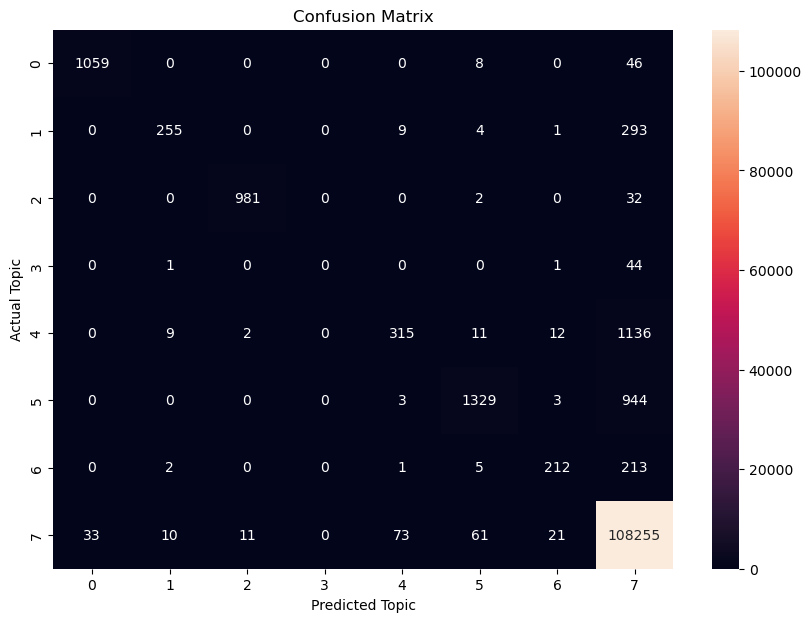

In [4]:
# Generate confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


cm = confusion_matrix(df['dominant_topic'], df['predicted_topic'])

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion Matrix')
plt.ylabel('Actual Topic')
plt.xlabel('Predicted Topic')
plt.show()

In [7]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
accuracy = accuracy_score(df['dominant_topic'], df['predicted_topic'])
print(f'Accuracy: {accuracy:.2f}')

precision_macro = precision_score(df['dominant_topic'], df['predicted_topic'], average='macro')
recall_macro = recall_score(df['dominant_topic'], df['predicted_topic'], average='macro')
f1_macro = f1_score(df['dominant_topic'], df['predicted_topic'], average='macro')

print(f'Precision (Macro): {precision_macro:.2f}')
print(f'Recall (Macro): {recall_macro:.2f}')
print(f'F1 Score (Macro): {f1_macro:.2f}')

# For micro averaging
precision_micro = precision_score(df['dominant_topic'], df['predicted_topic'], average='micro')
recall_micro = recall_score(df['dominant_topic'], df['predicted_topic'], average='micro')
f1_micro = f1_score(df['dominant_topic'], df['predicted_topic'], average='micro')

print(f'Precision (Micro): {precision_micro:.2f}')
print(f'Recall (Micro): {recall_micro:.2f}')
print(f'F1 Score (Micro): {f1_micro:.2f}')

# For weighted averaging
precision_weighted = precision_score(df['dominant_topic'], df['predicted_topic'], average='weighted')
recall_weighted = recall_score(df['dominant_topic'], df['predicted_topic'], average='weighted')
f1_weighted = f1_score(df['dominant_topic'], df['predicted_topic'], average='weighted')

print(f'Precision (Weighted): {precision_weighted:.2f}')
print(f'Recall (Weighted): {recall_weighted:.2f}')
print(f'F1 Score (Weighted): {f1_weighted:.2f}')


Accuracy: 0.97
Precision (Macro): 0.80
Recall (Macro): 0.58
F1 Score (Macro): 0.65
Precision (Micro): 0.97
Recall (Micro): 0.97
F1 Score (Micro): 0.97
Precision (Weighted): 0.97
Recall (Weighted): 0.97
F1 Score (Weighted): 0.97


/Users/alancheung/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/alancheung/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
